In [1]:
from einops import rearrange, repeat
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import trange
import pywt

from drumblender.utils.modal_analysis import CQTModalAnalysis
from drumblender.synths import ModalSynthFreqs, WaveletConvOLA

# Auxiliary functions extracted from nbdev
from aux_functions import load_audio_torch, ddsp_msfft_loss

/homes/fsc01/.conda/envs/drumblender/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modal + DWT Transients approximation
Finetuning amplitudes and DWT-level filters

## Tom Drum

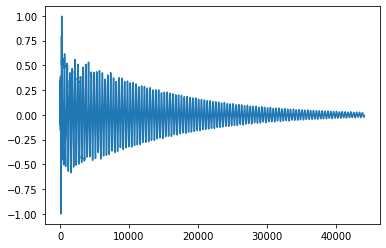

In [2]:
target, sr = load_audio_torch("audio/db_tom_1.wav")

# Pad to 1 second
if target.shape[1] < sr:
    target = torch.nn.functional.pad(target, (0, sr - target.shape[1]))

plt.plot(target[0].numpy())
ipd.Audio(target[0].numpy(), rate=sr)

### Constant-Q Spectrogram

In [3]:
hop_length = 64
fmin = 20.0
n_bins = 96
bins_per_octave = 12
cqt_analysis = CQTModalAnalysis(
    sample_rate=sr,
    hop_length=hop_length,
    fmin=fmin,
    n_bins=n_bins,
    bins_per_octave=bins_per_octave,
    num_modes=30,
    pad_mode="reflect",
)

CQT kernels created, time used = 0.1838 seconds


## Modal Resynthesis

torch.Size([1, 30, 690]) torch.Size([1, 30, 690]) torch.Size([1, 30, 690])


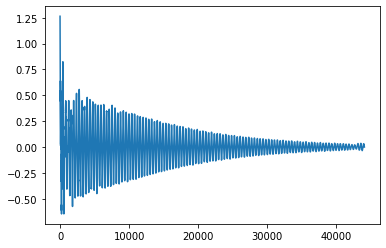

In [4]:
freqs, amps, phases = cqt_analysis(target)
print(freqs.shape, amps.shape, phases.shape)

freq_env = 2 * np.pi * freqs / sr
phase_start = phases[:,:,0]

modal_synth = ModalSynthFreqs(window_size=hop_length*2)


modal_out = modal_synth((amps,freq_env,phase_start))
plt.plot(modal_out[0].numpy())
ipd.Audio(modal_out[0].numpy(), rate=sr)

## Fine tuning modal amplitudes and phases
Using DDSP MS Spectrogram Loss

In [5]:
class DDSPFineTuneDrum:

    def __init__(self, opt_synth, iters=2000, lr=1e-3, scales = [1024,512,128], overlap=0.5):
        self.synth = opt_synth
        self.iters = iters
        self.lr = lr
        self.opt = torch.optim.Adam(self.synth.parameters(), lr=self.lr)
        self.loss_log = []
        self.scales = scales
        self.overlap = overlap
    
    def __call__(self, x):
        
        t = trange(self.iters, desc='Error', leave=True)
        for i in t:
            
            # Compute the sinusoid with updated paraetmers
            x_hat = self.synth()
            #print(x_hat.size())
            err = ddsp_msfft_loss(x,x_hat,self.scales,self.overlap)

            self.loss_log.append(err.detach().numpy())
            
            # Update tqdm description
            t.set_description(f"Error: {err.detach().numpy()}")

            # Optimize
            self.opt.zero_grad()
            err.backward()
            self.opt.step()

In [6]:
class ModalDWTTuner(nn.Module):
    def __init__(self,
                 window_size : int,
                 wavelet_num_windows : int,
                 freqs : torch.Tensor,
                 amps : torch.Tensor,
                 phases : torch.Tensor,
                 sr : int,
                 wavelet_type='db5',
                 use_random_idwt = False):
        super().__init__()
        self.modal_synth = ModalSynthFreqs(window_size)
        self.wavelet_conv = WaveletConvOLA(window_size,wavelet_num_windows,
                                           wavelet=wavelet_type)
        #self.freqs = self.register_buffer('modal freqs',freqs)
        self.freqs = freqs
        self.amps = nn.Parameter(amps,requires_grad=True)
        self.phases = nn.Parameter(phases,requires_grad=True)
        
        n_levels = int(np.round(np.log2(window_size)))
        # For this filter, kw = 10, since using 'db5' wavelet
        
        if(use_random_idwt):
            filters = torch.rand(amps.shape[0],wavelet_num_windows,n_levels,2,10)
        else:
            filters = self.create_idwt_filters(amps.shape[0],wavelet_num_windows,n_levels,
                                               wavelet_type)

        self.idwt_filters = nn.Parameter(filters.clone(),requires_grad=True)
        self.sr = sr
    
    def create_idwt_filters(self,batch_size,num_windows,num_levels,wavelet_type):
        wavelet = pywt.Wavelet(wavelet_type)
        wavelet_filters = wavelet.filter_bank

        rec_lo = torch.tensor(wavelet_filters[2]).unsqueeze(0)
        rec_hi = torch.tensor(wavelet_filters[3]).unsqueeze(0)
        filter = torch.concat((rec_lo, rec_hi), dim=0)

        # Copy filters: batch, num_windows, num_levels, type of filter, filter kernel
        idwt_filters = repeat(
            filter, "t f -> b w l t f", b=batch_size, w=num_windows, l=num_levels
        )
        return idwt_filters
    
    def forward(self):
        freq_env = 2 * np.pi * self.freqs / self.sr
        modes = self.modal_synth((self.amps,freq_env,self.phases))
        wavelet_out = self.wavelet_conv(modes,self.idwt_filters)
        tuner_out = torch.cat( (wavelet_out,modes[:,wavelet_out.shape[1]:]),dim=-1)

        return tuner_out
        

Optimize from proper idwt

In [7]:
window_size = hop_length*2
num_windows = 8
db5_tuner = ModalDWTTuner(window_size,num_windows,freqs,amps,phase_start,sr,use_random_idwt=False)

optimize = DDSPFineTuneDrum(db5_tuner, iters=50, lr=1e-3)
optimize(target)

Error: 3.624990940093994: 100%|██████████| 50/50 [01:46<00:00,  2.13s/it] 


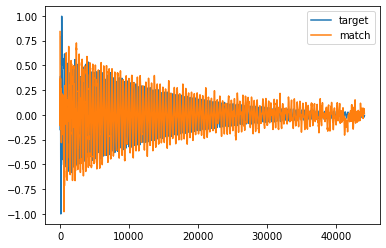

In [8]:
x = db5_tuner()

plt.plot(target[0].detach().numpy(), label="target")
plt.plot(x[0].detach().numpy(), label="match")
plt.legend()
plt.show()

ipd.display(ipd.Audio(x[0].detach().numpy(), rate=sr))
ipd.display(ipd.Audio(target[0].detach().numpy(), rate=sr))

Optimize from random idwt weights

In [9]:
window_size = hop_length*2
num_windows = 8
rnd_tuner = ModalDWTTuner(window_size,num_windows,freqs,amps,phase_start,sr,use_random_idwt=True)


optimize = DDSPFineTuneDrum(rnd_tuner, iters=200, lr=1e-3)
optimize(target)

Error: 2.542792797088623: 100%|██████████| 200/200 [07:04<00:00,  2.12s/it] 


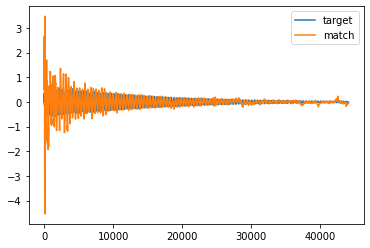

In [10]:
x = rnd_tuner()

plt.plot(target[0].detach().numpy(), label="target")
plt.plot(x[0].detach().numpy(), label="match")
plt.legend()
plt.show()

ipd.display(ipd.Audio(x[0].detach().numpy(), rate=sr))
ipd.display(ipd.Audio(target[0].detach().numpy(), rate=sr))